In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/1d/bias')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations/fc_abc.yaml')

In [4]:
import sys
sys.path.append(ROOT)

In [5]:
import torch
import pickle
from utils.tools import load_pickle

from utils.tools import read_yaml, set_random_seeds
from utils.plot.abc_parameterizations.initializations import *
from utils.plot.abc_parameterizations.one_d_functions import *
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected import muP, ipllr, ipllr_bias

In [6]:
from utils.plot.abc_parameterizations.one_d_functions import *

## Set variables

In [7]:
SEED = 42
N_SAMPLES = 100
N_TRAIN = 10
BASE_LR = 0.2

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)
base_config = ModelConfig(config_dict)

# modify config for this notebook
base_config.architecture['input_size'] = 1
base_config.architecture['output_size'] = 1
base_config.architecture['bias'] = False
base_config.activation.name = 'relu'
base_config.loss.name = 'mse'
base_config.optimizer.params['lr'] = BASE_LR

In [8]:
xs, ys = generate_1d_data(n_samples=10)

In [9]:
batch_xs = torch.unsqueeze(xs, 1)
batch_ys = torch.unsqueeze(ys, 1)

In [10]:
batches = [(batch_xs, batch_ys) for _ in range(3)]

## Define models

In [15]:
WIDTHS = [1024]
N_WARMUP_STEPS = 1  # 4
L = 4
N_TRIALS = 3  # 5
N_EPOCHS = 1000 # 6000

In [16]:
name_to_model_dict = {
    'muP': muP.FCmuP,
    'IPLLR': ipllr.FcIPLLR,
    'IPLLR-calibrate': ipllr.FcIPLLR,
    'IPLLR-bias': ipllr_bias.FcIPLLRBias
}

In [17]:
models_dict = dict()
for name, model in name_to_model_dict.items():
    models_dict[name] = dict()
    for width in WIDTHS:  # define models with different widths
        # first modify the base common config
        config = deepcopy(base_config)
        config.name = name
        config.architecture['width'] = width
        config.architecture['n_layers'] = L + 1
        
        if name == 'IPLLR':
            scheduler_config = {'name': 'warmup_switch', 
                                'params': {'n_warmup_steps': N_WARMUP_STEPS,
                                           'calibrate_base_lr': False,
                                           'default_calibration': False}}
            config.scheduler = BaseConfig(scheduler_config)
            config.optimizer.params['lr'] = BASE_LR
            
            models_dict[name][width] = [name_to_model_dict[name](config, lr_calibration_batches=batches) 
                                        for _ in range(N_TRIALS)]
            
        if name == 'IPLLR-calibrate':
            scheduler_config = {'name': 'warmup_switch', 
                                'params': {'n_warmup_steps': N_WARMUP_STEPS,
                                           'calibrate_base_lr': True,
                                           'default_calibration': False}}
            config.scheduler = BaseConfig(scheduler_config)
            config.optimizer.params['lr'] = BASE_LR
            
            models_dict[name][width] = [name_to_model_dict[name](config, lr_calibration_batches=batches) 
                                        for _ in range(N_TRIALS)]
            
        elif name == 'muP':
            config.optimizer.params['lr'] = BASE_LR
            config.scheduler = None
            models_dict[name][width] = [name_to_model_dict[name](config) for _ in range(N_TRIALS)]
            
        elif name == 'IPLLR-bias':
            scheduler_config = {'name': 'warmup_switch', 
                                'params': {'n_warmup_steps': N_WARMUP_STEPS,
                                           'calibrate_base_lr': False,
                                           'default_calibration': False}}
            config.scheduler = BaseConfig(scheduler_config)
            config.optimizer.params['lr'] = BASE_LR
            
            models_dict[name][width] = [name_to_model_dict[name](config, lr_calibration_batches=batches) 
                                        for _ in range(N_TRIALS)]

initial base lr : [0.4, 10.155464172363281, 11.788535118103027, 10.483081817626953, 0.41236743330955505]
initial base lr : [0.4, 8.618428230285645, 10.950209617614746, 10.429387092590332, 0.41009098291397095]
initial base lr : [0.4, 10.269235610961914, 12.394826889038086, 11.247917175292969, 0.41932031512260437]


### Set U and v to be the same for all models

In [28]:
model = ipllr_bias.FcIPLLRBias(config, lr_calibration_batches=batches)

In [55]:
list(model.input_layer.parameters())

[Parameter containing:
 tensor([[ 0.6550],
         [-1.3727],
         [-0.7894],
         ...,
         [ 0.8724],
         [ 0.2954],
         [-0.1469]], requires_grad=True),
 Parameter containing:
 tensor([ 1.8004,  0.9770,  2.3789,  ...,  2.2335, -1.9682, -1.9025],
        requires_grad=True)]

In [56]:
model.input_layer.weight

Parameter containing:
tensor([[ 0.6550],
        [-1.3727],
        [-0.7894],
        ...,
        [ 0.8724],
        [ 0.2954],
        [-0.1469]], requires_grad=True)

In [58]:
model = torch.nn.Linear(100, 100, bias=True)
model

Linear(in_features=100, out_features=100, bias=True)

In [64]:
param_groups = [{'params': model.weight, 'lr': 0.01, 'name': 'weight_1'},
                {'params': model.bias, 'lr': 0.01, 'name': 'bias_1'}]

In [65]:
opt = torch.optim.SGD(param_groups, lr=1e-6)

In [67]:
for idx, p in enumerate(opt.param_groups):
    print(idx, p)

0 {'params': [Parameter containing:
tensor([[-5.0187e-03, -3.5773e-02,  6.2844e-02,  ...,  5.5756e-03,
         -8.0887e-02, -5.0745e-02],
        [-4.8881e-02,  5.0271e-02, -7.3546e-02,  ..., -6.5884e-02,
         -6.1010e-02,  9.8999e-02],
        [ 9.1275e-02, -1.2204e-05, -9.4724e-02,  ..., -6.7117e-02,
          5.0205e-02, -5.6698e-02],
        ...,
        [ 2.8317e-02, -5.8299e-02,  5.0791e-02,  ...,  3.9147e-02,
          1.6793e-02, -7.4821e-02],
        [ 6.2881e-02, -9.9066e-02, -7.9120e-02,  ...,  5.8012e-02,
         -7.4543e-02, -6.7095e-02],
        [ 3.8998e-02,  5.7524e-02,  4.2673e-02,  ...,  7.4671e-02,
          6.4881e-02,  4.0644e-03]], requires_grad=True)], 'lr': 0.01, 'name': 'weight_1', 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}
1 {'params': [Parameter containing:
tensor([ 0.0983,  0.0020, -0.0613,  0.0415,  0.0022, -0.0641,  0.0204, -0.0294,
        -0.0602, -0.0981, -0.0171, -0.0911, -0.0012,  0.0858, -0.0585, -0.0726,
        -0.02

In [66]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[-5.0187e-03, -3.5773e-02,  6.2844e-02,  ...,  5.5756e-03,
            -8.0887e-02, -5.0745e-02],
           [-4.8881e-02,  5.0271e-02, -7.3546e-02,  ..., -6.5884e-02,
            -6.1010e-02,  9.8999e-02],
           [ 9.1275e-02, -1.2204e-05, -9.4724e-02,  ..., -6.7117e-02,
             5.0205e-02, -5.6698e-02],
           ...,
           [ 2.8317e-02, -5.8299e-02,  5.0791e-02,  ...,  3.9147e-02,
             1.6793e-02, -7.4821e-02],
           [ 6.2881e-02, -9.9066e-02, -7.9120e-02,  ...,  5.8012e-02,
            -7.4543e-02, -6.7095e-02],
           [ 3.8998e-02,  5.7524e-02,  4.2673e-02,  ...,  7.4671e-02,
             6.4881e-02,  4.0644e-03]], requires_grad=True)],
  'lr': 0.01,
  'name': 'weight_1',
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False},
 {'params': [Parameter containing:
   tensor([ 0.0983,  0.0020, -0.0613,  0.0415,  0.0022, -0.0641,  0.0204, -0.0294,
           -0.0602, -0.0981, -0.0171, -0

In [29]:
model.optimizer._step_count

0

In [30]:
model.scheduler._step_count

1

In [31]:
model.scheduler.optimizer._step_count

0

In [32]:
model.scheduler.current_lrs

[33554432.0, 1073741824.0, 33554432.0, 1048576.0, 1024]

In [33]:
model.scheduler.initial_lrs

[33554432.0, 1073741824.0, 33554432.0, 1048576.0, 1024]

In [34]:
model.scheduler.warm_lrs

[1024, 1048576, 1048576, 1048576, 1024]

In [35]:
L

4

In [36]:
model.n_layers

5

In [39]:
width = WIDTHS[0]
model.scheduler.initial_lrs == [width ** (5/2)] + [width ** ((L - l +4)/2) for l in range(2, 5)] + [width]

True

In [40]:
fit_model(model, batch_xs, batch_ys, n_epochs=1, verbose=True)

loss at step 1 : 0.74110


In [41]:
model.optimizer._step_count

1

In [42]:
model.scheduler._step_count

2

In [44]:
model.scheduler.current_lrs

[1024, 1048576, 1048576, 1048576, 1024]

In [45]:
model.input_layer.weight.detach().data

tensor([[ 0.6550],
        [-1.3727],
        [-0.7894],
        ...,
        [ 0.8724],
        [ 0.2954],
        [-0.1469]])

In [46]:
model.input_layer.bias.detach().data

tensor([ 1.8004,  0.9770,  2.3789,  ...,  2.2335, -1.9682, -1.9025])

In [47]:
layer_key = "layer_{:,}_intermediate".format(2)
layer = model.intermediate_layers.layer_2_intermediate

In [48]:
layer.weight.detach().data

tensor([[-2.1158,  0.2525,  2.7786,  ...,  0.8250,  1.0001, -2.6343],
        [-0.0940,  0.0305,  3.0348,  ...,  0.3697, -3.9926,  1.1799],
        [ 1.2752,  1.0300,  1.3944,  ...,  2.5699,  0.4770,  3.2201],
        ...,
        [ 1.1921,  0.6359,  0.4159,  ...,  0.0791, -1.2647,  0.9204],
        [ 0.2152,  0.0865,  2.7518,  ...,  0.6253,  2.5385,  3.8921],
        [ 0.5943, -2.0501, -0.4106,  ..., -0.9714, -2.8329,  0.4031]])

In [49]:
layer.bias.detach().data

tensor([-6.1163e-02, -3.5384e+02,  3.1898e+02,  ...,  1.4192e+02,
         1.2064e+01,  2.4727e+02])

In [50]:
layer_key = "layer_{:,}_intermediate".format(2)
layer = model.intermediate_layers.layer_3_intermediate

In [51]:
layer.weight.detach().data

tensor([[-0.9251,  0.5542,  0.1670,  ...,  1.4549,  1.8350,  2.3648],
        [-0.5994, -1.8000, -0.8430,  ..., -0.4752,  0.7974,  1.1876],
        [-1.3247, -1.6526, -0.6139,  ..., -0.3124, -2.3140,  0.9895],
        ...,
        [ 0.2732, -0.3318,  0.0299,  ..., -1.0855,  2.6213,  0.7247],
        [ 0.7139,  0.0047,  2.7591,  ..., -2.3016,  0.9258, -0.0244],
        [-0.1886, -0.4243,  1.0949,  ..., -2.1087, -0.1465, -0.8754]])

In [52]:
layer.bias.detach().data

tensor([ -43.9776, -326.0381, -278.4571,  ..., -226.9686,   -0.7365,
        -177.1892])

In [18]:
# COMMENT that part because of the bias in IPLLR-bias

#for name in models_dict.keys():
#    if name != 'muP':
#        for width in WIDTHS:
#            for i in range(N_TRIALS):
#                muP = models_dict['muP'][width][i]
#                model = models_dict[name][width][i]
#                with torch.no_grad():
#                    model.copy_initial_params_from_model(muP, check_model=True)
#                    model.initialize_params()

In [19]:
#for width in WIDTHS:
#    for ipllr in models_dict['IPLLR'][width]:
        # re-calibrate lr with new weights copied from muP
#        initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=True)
#        ipllr.scheduler._set_param_group_lrs(initial_base_lrs)

        # scale lr of first layer by (d+1)
#        ipllr.scheduler.warm_lrs[0] = ipllr.scheduler.warm_lrs[0] * (ipllr.d + 1)

In [20]:
batch_xs = torch.unsqueeze(xs, 1)
batch_ys = torch.unsqueeze(ys, 1)
for name in models_dict.keys():
    for width in WIDTHS:
        for model in models_dict[name][width]:
            fit_model(model, batch_xs, batch_ys, n_epochs=N_EPOCHS)

#for name in ['IPLLR']:
#for name in ['muP']:
#    for width in WIDTHS:
#        for model in models_dict[name][width]:
#            fit_model(model, batch_xs, batch_ys, n_epochs=N_EPOCHS)

### muP

In [21]:
#name = 'muP'
#for k in range(len(models_dict[name][1024])):
#    model = models_dict[name][1024][k]
#    plt.figure(figsize=(12, 6))
#    plot_model(model, xs, ys, label=name, scatter=True)
#    plt.title('muP after {} epochs with lr = {} trial {:,}'.format(N_EPOCHS, model.base_lr, k + 1))
#    plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trial_{}.png'.format(name, model.base_lr, N_EPOCHS, k+1)))
    # plt.ylim(-0.0001, 0.0001)
#    plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


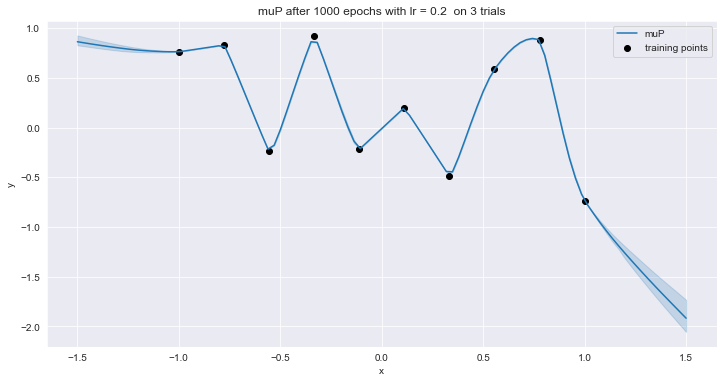

In [22]:
name = 'muP'
base_lr = models_dict[name][1024][0].base_lr
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True, x_max=1.5)
# plt.ylim(-0.0001, 0.0001)
plt.title('muP after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))
plt.show()

### IP-LLLR

In [23]:
#name = 'IPLLR'
#for k in range(len(models_dict[name][1024])):
#    model = models_dict[name][1024][k]
#    plt.figure(figsize=(12, 6))
#    plot_model(model, xs, ys, label=name, scatter=True)
#    plt.title('IPLLR after {} epochs with lr = {} trial {:,}'.format(N_EPOCHS, model.base_lr, k + 1))
    #plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trial_{}.png'.format(name, model.base_lr, N_EPOCHS, k+1)))

    # plt.ylim(-0.0001, 0.0001)
#    plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


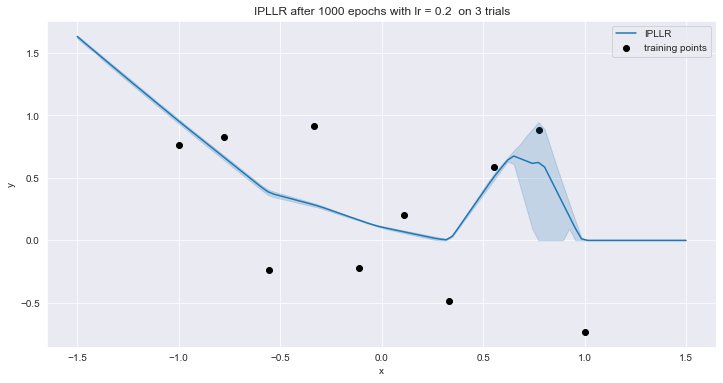

In [24]:
name = 'IPLLR'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True, x_max=1.5)
# plt.ylim(-0.0001, 0.0001)
plt.title('IPLLR after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


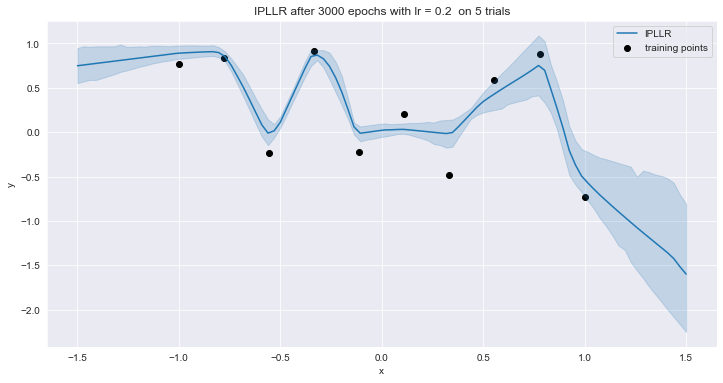

In [23]:
name = 'IPLLR'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True, x_max=1.5)
# plt.ylim(-0.0001, 0.0001)
plt.title('IPLLR after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()

### IP-LLLR calibrate

In [25]:
#name = 'IPLLR'
#for k in range(len(models_dict[name][1024])):
#    model = models_dict[name][1024][k]
#    plt.figure(figsize=(12, 6))
#    plot_model(model, xs, ys, label=name, scatter=True)
#    plt.title('IPLLR after {} epochs with lr = {} trial {:,}'.format(N_EPOCHS, model.base_lr, k + 1))
    #plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trial_{}.png'.format(name, model.base_lr, N_EPOCHS, k+1)))

    # plt.ylim(-0.0001, 0.0001)
#    plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


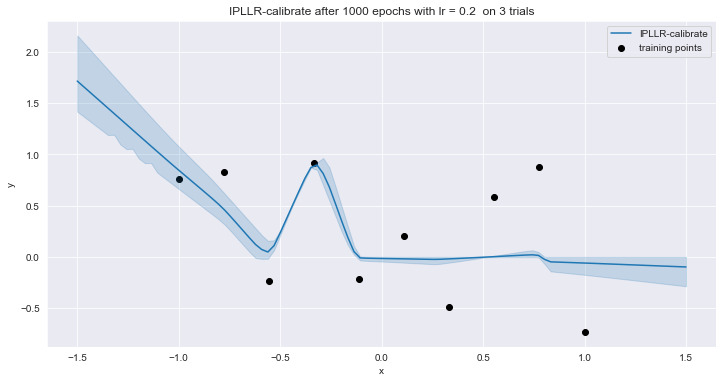

In [26]:
name = 'IPLLR-calibrate'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True, x_max=1.5)
# plt.ylim(-0.0001, 0.0001)
plt.title('IPLLR-calibrate after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


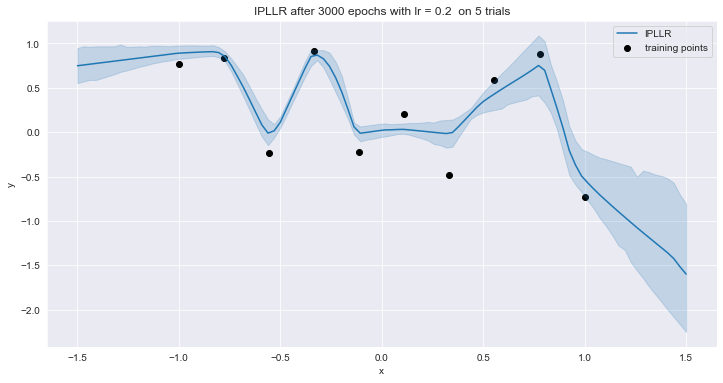

In [23]:
name = 'IPLLR-calibrate'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True, x_max=1.5)
# plt.ylim(-0.0001, 0.0001)
plt.title('IPLLR-calibrate after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()

### IP-LLLR bias

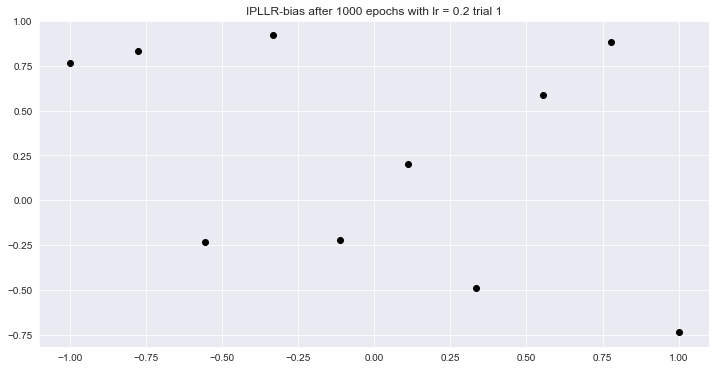

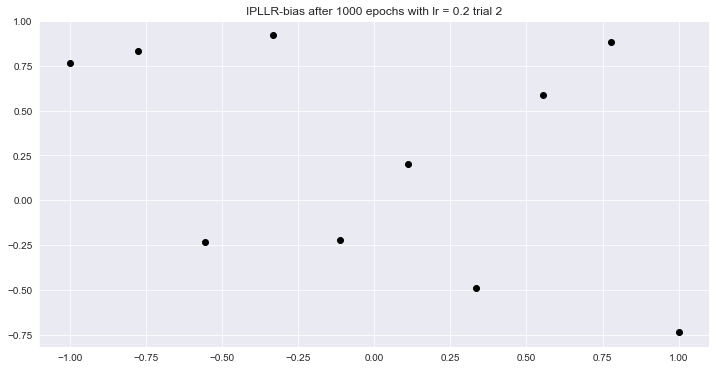

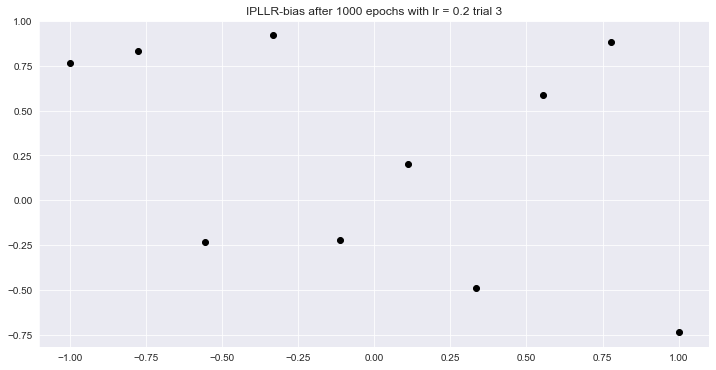

In [27]:
name = 'IPLLR-bias'
for k in range(len(models_dict[name][1024])):
    model = models_dict[name][1024][k]
    plt.figure(figsize=(12, 6))
    plot_model(model, xs, ys, label=name, scatter=True)
    plt.title('IPLLR-bias after {} epochs with lr = {} trial {:,}'.format(N_EPOCHS, model.base_lr, k + 1))
    #plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trial_{}.png'.format(name, model.base_lr, N_EPOCHS, k+1)))

    # plt.ylim(-0.0001, 0.0001)
    plt.show()

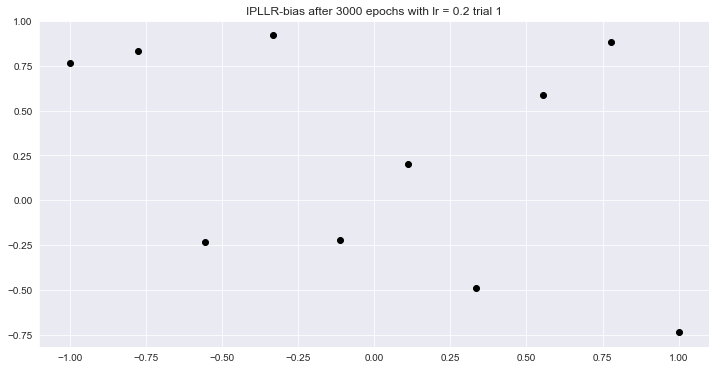

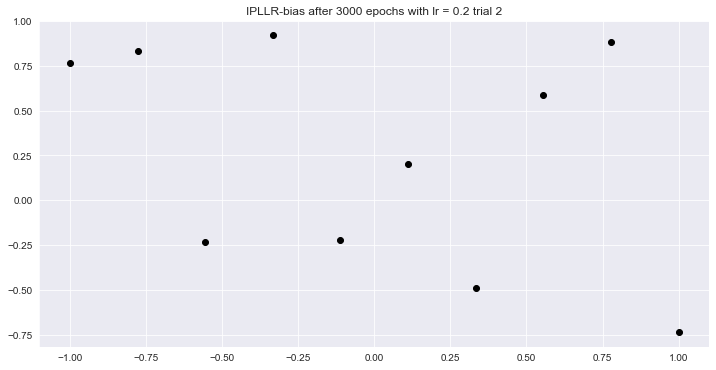

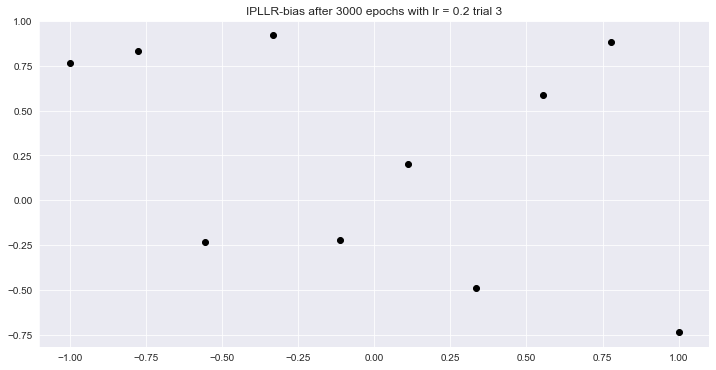

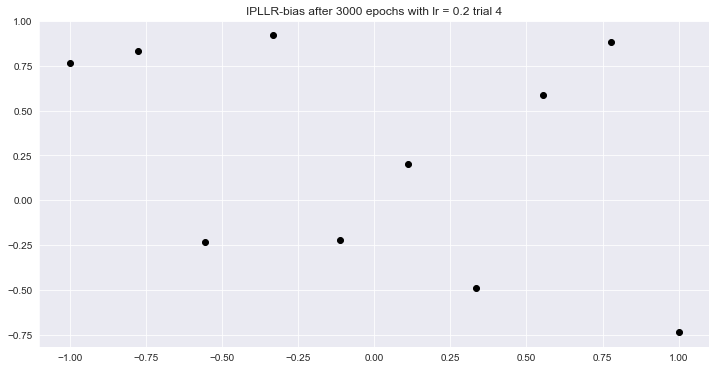

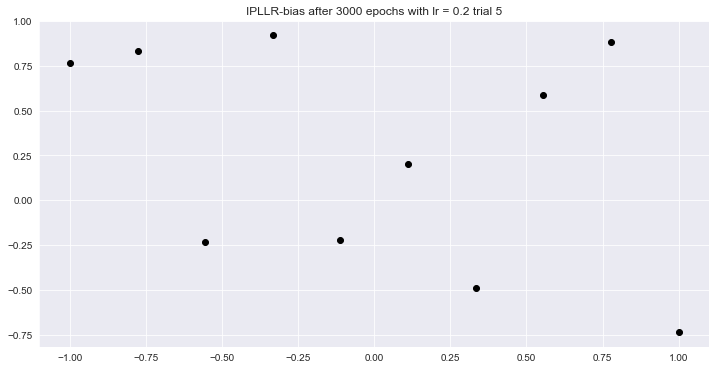

In [24]:
name = 'IPLLR-bias'
for k in range(len(models_dict[name][1024])):
    model = models_dict[name][1024][k]
    plt.figure(figsize=(12, 6))
    plot_model(model, xs, ys, label=name, scatter=True)
    plt.title('IPLLR-bias after {} epochs with lr = {} trial {:,}'.format(N_EPOCHS, model.base_lr, k + 1))
    #plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trial_{}.png'.format(name, model.base_lr, N_EPOCHS, k+1)))

    # plt.ylim(-0.0001, 0.0001)
    plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


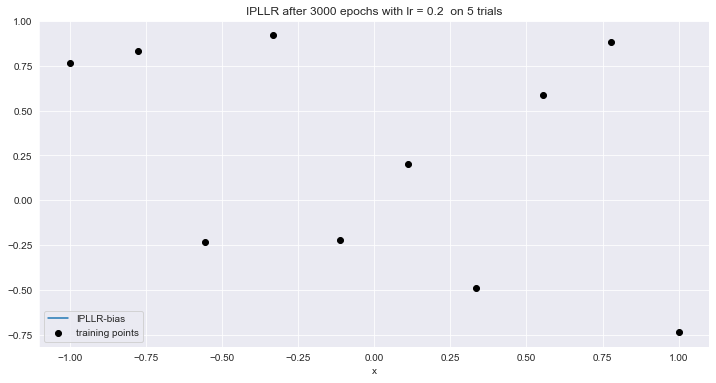

In [25]:
name = 'IPLLR-bias'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True)
# plt.ylim(-0.0001, 0.0001)
plt.title('IPLLR after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


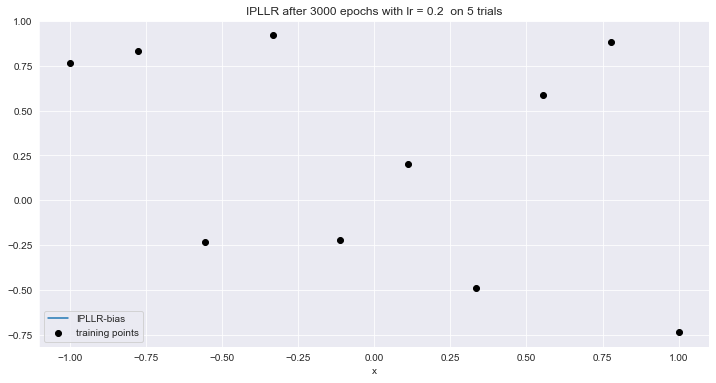

In [26]:
name = 'IPLLR-bias'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True, x_max=1.5)
# plt.ylim(-0.0001, 0.0001)
plt.title('IPLLR after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()